In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import io
import scipy.io

import ssd_m as ssd

Using TensorFlow backend.


# Reuse Pretrained Model

I reuse the pretraining model, expanding number of classification to 196.
Firstly I load weights to original model and then extract the fourth layer of convolution which can detect contour well.
Secondly, for convenient, I modulize model into pieces of function, so can be easily adjusted to different dataset. 

In [2]:
num_classes = 197
img_size = (300, 300)

ssd model only need 6 layers to form which is for different purpose.

In [3]:
# ssd300 = SSD300((300, 300, 3), 21).model()
ssd300 = ssd.default_model()
ssd300.load_weights('weights_SSD300.hdf5')

_input = ssd300.get_layer('input').output
_conv4_3_norm = ssd300.get_layer('conv4_3_norm').output
_fc7 = ssd300.get_layer('fc7').output
_conv6_2 = ssd300.get_layer('conv6_2').output
_conv7_2 = ssd300.get_layer('conv7_2').output
_conv8_2 = ssd300.get_layer('conv8_2').output
_pool6 = ssd300.get_layer('pool6').output

consolidate aforementioned layers into new model we want

In [4]:
ssd_loc_layer = ssd.ssd_loc_layer(_conv4_3_norm, _fc7, _conv6_2, _conv7_2, _conv8_2, _pool6)
ssd_conf_layer = ssd.ssd_conf_layer(num_classes, _conv4_3_norm, _fc7, _conv6_2, _conv7_2, _conv8_2, _pool6)
ssd_prior_box_layer = ssd.ssd_prior_box_layer(img_size, _conv4_3_norm, _fc7, _conv6_2, _conv7_2, _conv8_2, _pool6)

model = ssd.model(num_classes, _input, ssd_loc_layer, ssd_conf_layer, ssd_prior_box_layer)

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 150, 150, 64) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

### Data preprocessing
Lengthy work...

In [6]:
batch_size = 1

path_imgs_train = os.path.join('data', 'cars_train')

annotation_train = scipy.io.loadmat('data/devkit/cars_train_annos.mat')

meta = scipy.io.loadmat('data/devkit/cars_meta.mat')

cls_name = meta['class_names'][0]
annotation_train = annotation_train['annotations'][0]

n_cls = cls_name.shape[0]

print("image size: {}".format(img_size))
print("number of classes: {}".format(n_cls))
print("number of training set: {}".format(annotation_train.shape[0]))

image size: (300, 300)
number of classes: 196
number of training set: 8144


lets check the distribution in our dataset

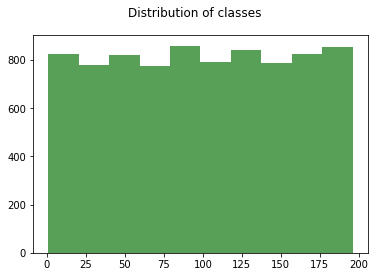

In [7]:
def histogram_brand(annotation):
    brands = np.array([brand for brand in [raw[-2] for raw in annotation] ])
    plt.hist(brands.ravel(), density=False, color='#117711', alpha=0.7)
    plt.suptitle('Distribution of classes')
    plt.show()
    
histogram_brand(annotation_train)

Annotaion contains data information included [xmin, ymin, xmax, ymax, label, image_path].

In [8]:
def unfold_annotation(annotation, dir_imgs, n_cls, img_size):
    bboxes = []
    uris = []
    cls_list = []
    
    def _process(annotation, dir_img, n_cls, img_size):
        n_obj = annotation[-2].shape[0]
        uri = os.path.join(dir_img, annotation[5][0])
        bbox = []
        cls_list = []
        for obj_id in range(n_obj):
            _xmin = float(annotation[0][obj_id][0])/img_size[1]
            _ymin = float(annotation[1][obj_id][0])/img_size[0]
            _xmax = float(annotation[2][obj_id][0])/img_size[1]
            _ymax = float(annotation[3][obj_id][0])/img_size[0]
            _cls_id = int(annotation[4][obj_id][0])
            cls = np.zeros((n_cls,))
            cls[_cls_id-1] = 1
            bbox.append([_xmin, _ymin, _xmax, _ymax])
            cls_list.append(cls)
        
        return np.array(bbox), uri, cls_list
    
    for ann in annotation:
        _box, _uri, _cls_list = _process(ann, dir_imgs, n_cls, img_size)
        bboxes.append(_box)
        uris.append(_uri)
        cls_list.append(_cls_list)
    
    return np.array(bboxes, dtype=np.float32), np.array(uris, dtype=np.str), np.array(cls_list, dtype=np.uint8)

In [9]:
bboxes_train, uris_train, cls_train = unfold_annotation(annotation_train, path_imgs_train, n_cls, img_size)
print("Shape of training boxes: {}".format(bboxes_train.shape))
print("Shape of training uri: {}".format(uris_train.shape))
print("Shape of training class: {}".format(cls_train.shape))

Shape of training boxes: (8144, 1, 4)
Shape of training uri: (8144,)
Shape of training class: (8144, 1, 196)


Loading predefined prior bbox data from packle, because SSD use pyramid projection to train and destruct prediction to original position.

In [10]:
from ssd_utils import BBoxUtility
import pickle

priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(n_cls+1, priors=priors)

# test
_test = bbox_util.assign_boxes(np.concatenate((bboxes_train[0:5][0], cls_train[0:5][0]), axis=1))
print("sample boxes shape: {}".format(_test.shape))

sample boxes shape: (7308, 209)


In [11]:
from utils.generate_data import Generator

total = float(uris_train.shape[0])
ratio = 0.8
size = int(total*ratio)

train = uris_train[:size], cls_train[:size], bboxes_train[:size]
test = uris_train[size:], cls_train[size:], bboxes_train[size:]

generator = Generator(train, test, bbox_util, batch_size=batch_size)
print("Size of training set: {}".format(size))
print("Size of validating set: {}".format(int(total-size)))

Size of training set: 6515
Size of validating set: 1629


In [12]:
# prevent to affect pretrained weights
def frozen_layers(model):
    freeze_layers = [
        'input', 'conv1_1', 'conv1_2', 'pool1',
        'conv2_1', 'conv2_2', 'pool2',
        'conv3_1', 'conv3_2', 'conv3_3', 'pool3'
    ]
    for layer in model.layers:
        if layer.name in freeze_layers:
            layer.trainable = False

frozen_layers(model)

### Happy time: training

In [13]:
import keras

# gradually decreased learning rate
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

# periodically store weights
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.ckpt',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [ ]:
from ssd_training import MultiboxLoss
# load pretrain
model.load_weights('checkpoints/weights.30-26.35.hdf5')

# loss function and optimiser
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(n_cls+1, neg_pos_ratio=2.0).compute_loss)

nb_epoch = 30
g_train = generator.generate(train=True)
g_test = generator.generate(train=False)
history = model.fit_generator(generator=g_train, steps_per_epoch=500,
                              epochs=nb_epoch, verbose=1, callbacks=callbacks,
                              validation_data=g_test, validation_steps=50)

Epoch 1/30
500/500 [==============================] - 129s 257ms/step - loss: 1.8915 - val_loss: 18.4774
Epoch 2/30
500/500 [==============================] - 128s 255ms/step - loss: 1.7818 - val_loss: 16.7136
Epoch 3/30
500/500 [==============================] - 128s 255ms/step - loss: 1.7849 - val_loss: 14.1734
Epoch 4/30
368/500 [=====================>........] - ETA: 32s - loss: 1.4582

In [ ]:
# from utils import demo

# demo.demo(model, 'data/cars_test/07657.jpg', bbox_util)